In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# The Making of the Riva German ASR Service

This notebook walks you through the end-to-end process that NVIDIA engineers and data scientists employed to develop the Riva German Automatic Speech Recognition (ASR) service, from raw transcribed audio data to a ready-to-serve Riva ASR service.

## Overview

The below diagram provides a high-level overview of the end-to-end engineering workflow required to realize the Riva German ASR service.


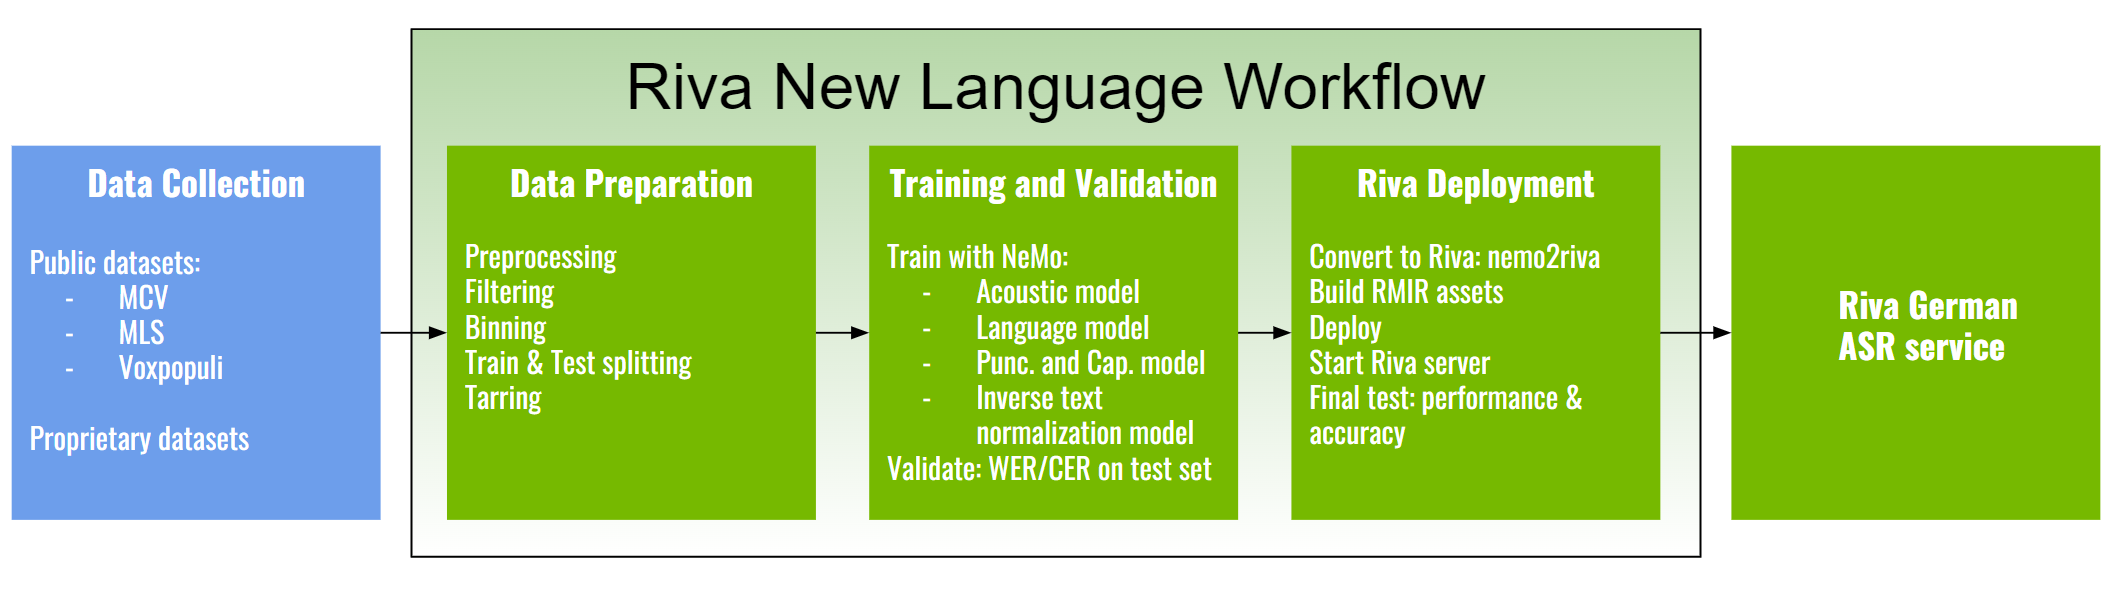

In [3]:
from IPython.display import Image
Image(filename='german-workflow.PNG')

Beyond the data collection phase, the new language workflow for Riva is divided into three major stages:
- Data preparation
- Training and validation
- Riva deployment

In the next sections, we look deeper into each of these stages.

## 1. Data collection
When adapting Riva to a whole new language, a large amount of high-quality transcribed audio data is critical for training high-quality acoustic models. 

For German, there are several significant sources of public datasets that we can readily leverage:

- [Mozila Common Voice](https://commonvoice.mozilla.org/en/datasets) (MCV) corpus 7.0, `DE` subset: 571 hours 
- [Multilingual LibriSpeech](http://www.openslr.org/94/) (MLS), `DE` subset: 1918 hours
- [Voxpopuli](https://ai.facebook.com/blog/voxpopuli-the-largest-open-multilingual-speech-corpus-for-ai-translation-and-more/), `DE` subset: 214 hours

The total amount of public datasets is ~2700 hours of transcribed German speech audio data. 

In addition, to train [world-class Riva models](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-overview.html#language-support), we acquired proprietary datasets, bringing the total number of data to ~3500 hours.

## 2. Data preparation

The data preparation phase carries out a series of preparation steps required to convert the diverse raw audio datasets into a uniform format that can be efficiently digested by NVIDIA NeMo toolkit. These steps are:

### 2.1. Data preprocessing

**Audio data**: Audio data acquired from various sources are inherently heterogeneous (file format, sample rate, bit depth, number of audio channels...). Therefore, as a preprocessing step, we build a separate data ingestion pipeline for each source and convert these audio data to a common format with the following characteristics:
- Wav format
- Bit depth: 16 bits
- Sample rate of 16 Khz
- Single audio channel

**Text data**: 

- Text Normalization converts text from written form into its verbalized form. It is used as a preprocessing step for preprocessing Automatic Speech Recognition (ASR) training transcripts. For German text normalization, we primarily leverage NeMo text normalization [library](https://github.com/NVIDIA/NeMo/tree/main/nemo_text_processing/text_normalization/de). In addition, we also also tried to convert all outdated German word spellings to modern spelling.

Dataset ingestion scripts are used to convert the various datasets into the standard manifest format expected by NeMo. Next, we build a text tokenizer.


**Tokenizer**: There are two popular encoding choices: character encoding and sub-word encoding. Sub-word encoding models are almost nearly identical to the character encoding models. The primary difference lies in the fact that a sub-word encoding model accepts a sub-word tokenized text corpus and emits sub-word tokens in its decoding step. 
Preparation of the tokenizer is made simple by the [process_asr_text_tokenizer.py script](https://github.com/NVIDIA/NeMo/blob/main/scripts/tokenizers/process_asr_text_tokenizer.py) in NeMo. We leverage this script to build the text corpus from the manifest directly, then create a tokenizer using that corpus.



### 2.2. Data cleaning/filtering

This step is carried out to filter out some outlying samples in the datasets. 

- Samples that are too long, too short or empty are filtered out.

- samples that are considered 'noisy', that is, samples having very high WER (word error rate) or CER (character error rate) with regard to a previously trained German model.


### 2.3. Binning

For training ASR models, audios with different lengths may be grouped into a batch. It would make it necessary to use paddings to make all the same length. These extra paddings is a significant source of computation waste. Splitting the training samples into buckets with different lengths and sampling from the same bucket for each batch would increase the computation efficiency. It may result into training speeedup of more than 2X. 

We leverage NeMo conversion [script](https://github.com/NVIDIA/NeMo/blob/v1.0.2/scripts/speech_recognition/convert_to_tarred_audio_dataset.py) to carry out this step.

### 2.4. Train and Test splitting

This step is a staple of the any deep learning and machine learning development pipeline, to ensure that the model is learning to generalize without overfitting the training data. For the test set, we additionally curated data that isn't from the same source as the training datasets, such as Youtube and TED talks.

### 2.5. Tarring

If experiments are run on a cluster with datasets stored on a distributed file system, the user will likely want to avoid constantly reading multiple small files and would prefer tarring their audio files. You can easily convert your existing NeMo-compatible ASR datasets using the conversion [script](https://github.com/NVIDIA/NeMo/blob/v1.0.2/scripts/speech_recognition/convert_to_tarred_audio_dataset.py).


## 3. Training and validation

The models in an ASR pipeline include:

- An **acoustic model**, that maps raw audio input to probabilities over text tokens at each time step.  This matrix of probabilities is fed into a decoder, that convert probabilities into a sequence of text tokens.
- A **language model**, that is optionally used in the decoding phase of the acoustic model output. 
- A **punctuation and capitalization (P&C) model**, that formats the raw transcript, augmenting with punctuation and capitalization.
- An **inverse text normalization (ITN) model**, that produces a desired written format from a spoken format.


### 3.1. Acoustic model

The acoustic model is by far the most important part of an ASR service. These are the most resource intensive models, requiring a large amount of data to train on powerful GPU servers or cluster. They also have the largest impact on the overall ASR quality.

**Model architecture**: The models we experimented for the German ASR pipeline include NeMo Citrinet and Conformer-CTC. The final model chosen for deployment of the Riva German ASR service (ver. 22.04) was a Conformer-CTC [model](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/models.html).

Conformer-CTC is a CTC-based variant of the Conformer model introduced in this [paper](https://arxiv.org/abs/2005.08100v1). Conformer-CTC has a similar encoder as the original Conformer but uses CTC loss and decoding instead of RNNT/Transducer loss, which makes it a non-autoregressive model. We also drop the LSTM decoder and instead use a linear decoder on the top of the encoder. This model uses the combination of self-attention and convolution modules to achieve the best of the two approaches, the self-attention layers can learn the global interaction while the convolutions efficiently capture the local correlations. The self-attention modules support both regular self-attention with absolute positional encoding, and also Transformer-XL’s self-attention with relative positional encodings.

**Training from scratch vs. cross-language transfer learning:** Cross-language transfer learning is especially helpful when training new models for low-resource languages. But even when a substantial amount of data is available, cross-language transfer learning can help boost the performance further. It is based on the idea that phoneme representation can be shared across different languages. See this [notebook](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/ASR_CTC_Language_Finetuning.ipynb) for an example of cross-language transfer learning.

We started the training of the final model from a [Nemo DE Conformer-CTC large model](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_de_conformer_ctc_large) (trained on MCV7.0 567 hours, MLS 1524 hours and VoxPopuli 214 hours), which itself was trained using an [English Conformer model](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_enes_conformer_ctc_large) as initialization. The process is illustrated as in the below figure.

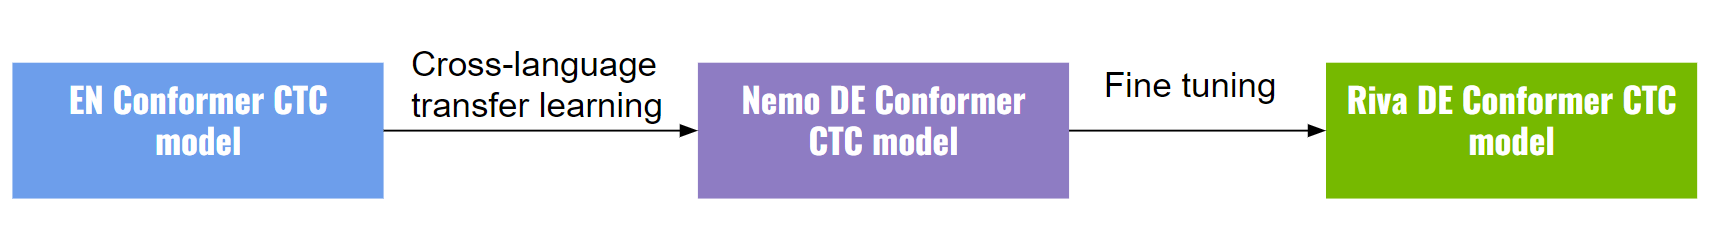

In [5]:
from IPython.display import Image
Image(filename='transfer-learning.PNG')

**Training script**: We leverage NeMo training [scripts](https://github.com/NVIDIA/NeMo/blob/v1.0.2/examples/asr/speech_to_text.py). You may find the example config files of Conformer-CTC model with character-based encoding at `<NeMo_git_root>/examples/asr/conf/conformer/conformer_ctc_char.yaml` and with sub-word encoding at `<NeMo_git_root>/examples/asr/conf/conformer/conformer_ctc_bpe.yaml`.

**Hyper-parameter setting**: For model fine-tuning, we employed an Adam optimizer with learning rate 1.0, beta parameters [0.8, 0.25], 0 weight decay for 250 epochs. 

**Training environment**: We trained the models on a GPU cluster comprising 64 GPUs.

### 3.2. Language model

Language model, combined with beam search in the decoding phase can further improve the quality of the ASR pipeline. In our experiments, we generally observe an additional 1-2% of WER reduction by using a simple n-gram model. 

The language models supported by Riva are n-gram model, which can be trained with the Kenlm toolkit. See Riva [documentation](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-customizing.html#training-language-models) for details on how to train and deploy a custom language model.

**Training data**: We create training set by combining all the transcript text in our ASR set, normalizing, cleaning then tokenizing (using the same tokenizer used for ASR transcript preprocessing mentioned above).

### 3.3. Punctuation and capitalization model

The Punctuation and Capitalization model consists of the pre-trained Bidirectional Encoder Representations from Transformers (BERT) followed by two token classification heads. One classification head is responsible for the punctuation task, the other one handles the capitalization task. 

The model was trained with BERT base multilingual cased checkpoint on a subset of data from the following sources:

- Tatoeba sentences
- MCV Corpus
- Proprietary datasets.

We employed a BERT-base model for the task and leverage NeMo [script](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/token_classification/punctuation_capitalization_train_evaluate.py) for the training part. 

See also NeMo [tutorial](https://github.com/NVIDIA/NeMo/blob/main/tutorials/nlp/Punctuation_and_Capitalization.ipynb) on the topic.

### 3.4. Inverse text normalization model

We leverage NeMo German text inverse normalization [module](https://github.com/NVIDIA/NeMo/tree/main/nemo_text_processing/inverse_text_normalization/de) for the task. NeMo ITN is based on weighted finite-state transducer (WFST) grammars. The tool uses Pynini to construct WFSTs, and the created grammars can be exported and integrated into Sparrowhawk (an open-source version of [the Kestrel TTS text normalization system](https://www.cambridge.org/core/journals/natural-language-engineering/article/abs/kestrel-tts-text-normalization-system/F0C18A3F596B75D83B75C479E23795DA)) for production.

With a functional NeMo installation, the German ITN grammars can be exported with the [pynini_export.py](https://github.com/NVIDIA/NeMo/blob/main/tools/text_processing_deployment/pynini_export.py) tool, found in NeMo/tools/text_processing_deployment, as follows:
```
python3 pynini_export.py --output_dir . --grammars itn_grammars --input_case cased --language de
```

This exports the `tokenizer_and_classify` and `verbalize` Fsts as OpenFst finite state archive (FAR) files, ready to be deployed with Riva.
```
[NeMo I 2022-04-12 14:43:17 tokenize_and_classify:80] Creating ClassifyFst grammars.
Created ./de/classify/tokenize_and_classify.far
Created ./de/verbalize/verbalize.far
```

To deploy these ITN rules with Riva, pass the FAR files to the `riva-build` command under these options:

```
riva-build speech_recognition
[--wfst_tokenizer_model WFST_TOKENIZER_MODEL]
[--wfst_verbalizer_model WFST_VERBALIZER_MODEL]
```

To learn more on how to build grammars from the ground-up, consult the NeMo Weighted Finite State Transducers (WSFT) [tutorial](https://github.com/NVIDIA/NeMo/blob/main/tutorials/text_processing/WFST_Tutorial.ipynb).

## 4. Riva deployment

With all the models trained, now it's the time to deploy the Riva service.

### BYO German models

Given the final `.nemo` model, here are the steps that need to be done to deploy on Riva:

- Download RIVA Quickstart scripts – it provides `nemo2riva`, `servicemaker`, `riva-speech-server` and `riva-speech-client` images

- Build `.riva` assets: using `nemo2riva` command in the `servicemaker` container. See examples of build command for different models and for offline and online ASR pipelines in the [Riva build documentation page]().

- Build `RMIR` assets: use the `riva-build` tool in the `servicemaker` container.

- Deploy the model and start the server


### Riva pretrained German models on NGC

All Riva German assets are published on NGC (including `.nemo`, `.riva`, `.tlt` and `.rmir` assets). You can use these models as starting points for your development.

**Acoustic models**:

- Citrinet ASR German: 
    - [Riva deployable version (.riva format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_de_de_citrinet/files?version=deployable_v2.0)
    - [Tao trainable version (.tlt format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_de_de_citrinet/files?version=trainable_v2.0)
    - [Nemo version (.nemo format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_de_citrinet_1024)
- Conformer ASR German
    - [Riva deployable version (.riva format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_de_de_conformer/files?version=deployable_v2.0)
    - [Tao trainable version (.tlt format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_de_de_conformer/files?version=trainable_v2.0)
    - [Nemo version (.nemo format)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/stt_de_conformer_ctc_large)
    
**Inverse text normalization models**: This model is an [OpenFST finite state archive (.far)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/inverse_normalization_de_de) for use within the opensource Sparrowhawk normalization engine and Riva.    

**Language model**:  These models are simple [4-gram language models](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_de_de_lm) trained with Kneser-Ney smoothing using KenLM. This directory also contains the decoder dictionary used by the Flashlight decoder.

**Punctuation and Capitalization models** - [Riva Punctuation and Capitalization model for German](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/punctuationcapitalization_de_de_bert_base). 

# Conclusion

In this notebook, we have guided you through the steps to realize the Riva German ASR service, from raw data to a ready-to-use service. 

You can follow the same process to setup a new German ASR service using your own data, or use the resources in this notebook to fine-tune parts of the pipeline with your own model and data.